# Energy-based sequential sampling for PSD-matrix approximation - Example

This notebook illustrates the gradient-based column-sampling strategy described in [*Energy-based sequential sampling for PSD-matrix approximation*](https://hal.science/hal-04102664/).

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from scipy.stats import unitary_group

## 1. Construction of the random matrix


Below, we generate random eigenvalues $\lambda_{1}, \ldots, \lambda_{N}$, $N=1{,}500$, from a log-normal distribution with parameters $\mu = -2.5$ and $\sigma = 3$. 

In [2]:
N = 1500
gauss_loc = -2.5
gauss_sd = 3
random_seed = 765 # set a seed for reproducibility

rng = np.random.default_rng(random_seed)    
K_eigval_vec = np.flip(np.sort(np.exp(rng.normal(gauss_loc, gauss_sd, N))))

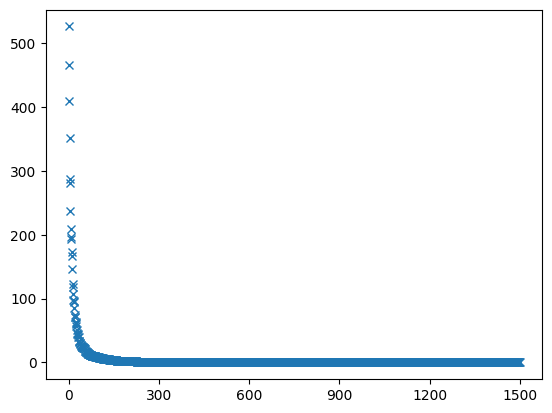

In [3]:
fig, ax = plt.subplots()
ax.plot(K_eigval_vec, marker="x", linestyle="none")
ax.set_xticks([0, 300, 600, 900, 1200, 1500])
plt.show()

We next generate a random $N\times N$ unitary matrix, and define $\mathbf{K}$ from the obtained random eigenvalues and eigenvectors. 

In [4]:
ug = unitary_group(dim=N, seed=np.random.default_rng(2))

In [5]:
P_mat = ug.rvs()
D_mat = np.diag(K_eigval_vec)
K_mat = P_mat @ D_mat @ P_mat.conj().T

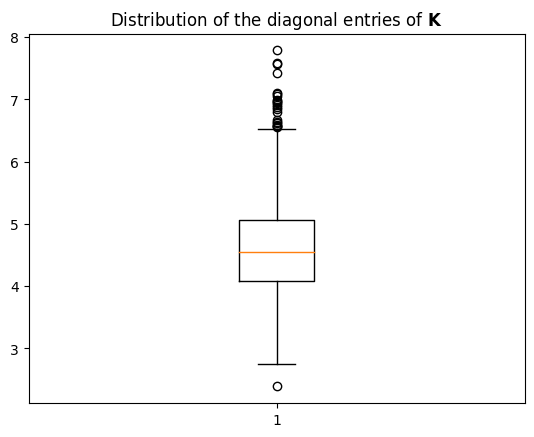

In [6]:
plt.boxplot(np.diag(K_mat).real)
plt.title("Distribution of the diagonal entries of $\mathbf{K}$")
plt.show()

## 2. Preliminary computations

We compute $\mathbf{S} = \overline{\mathbf{K}} \odot \mathbf{K}$, $\boldsymbol{\mathfrak{g}} = \mathbf{S} \boldsymbol{1}$, and $\|\mathbf{K}\|_{\mathrm{F}}^{2} = \boldsymbol{1}^{*} \boldsymbol{\mathfrak{g}}$. 

In [7]:
S_mat = (K_mat * K_mat.conj()).real
g_vec = S_mat @ np.ones(N)
K_Frob_sq = np.ones(N) @ g_vec
K_Frob_sq

1346482.602309611

## 3. Tool functions

Below, we implement functions performing:
* the evaluation of $C_{\mathrm{tr}}$, $C_{\mathrm{F}}$, $C_{\mathrm{P}}$ and $C_{\mathrm{PP}}$;
* Algorithm 1 (FW with optimal step size);
* Algorithm 1 (Stochastic modified FW variant).

For the S-MFW variant of Algorithm 1, we replace the exact target potential $\boldsymbol{\mathfrak{g}}$
by a stochastic approximation $\hat{\boldsymbol{\mathfrak{g}}}_{\mathrm{sym}}$ which takes advantage of the symmetry of $\mathbf{S}$.

In [8]:
## error maps C_tr, C_F, C_P, C_PP
def comp_Nystrom_errors(v_supp, K_mat):
    if len(v_supp) == 1:
        K_II_inv_mat = 1 / K_mat[v_supp[0], v_supp[0]]
        K_dotI_mat = K_mat[:, v_supp[0]]
        K_hat_I_mat = np.outer(K_dotI_mat, K_dotI_mat.conj()) * K_II_inv_mat
    else:
        K_II_inv_mat = np.linalg.pinv(K_mat[np.ix_(v_supp, v_supp)], hermitian=True)
        K_dotI_mat = K_mat[:,v_supp]
        K_hat_I_mat = K_dotI_mat @ K_II_inv_mat @ K_dotI_mat.conj().T
        
    err_mat = K_mat - K_hat_I_mat
    trace_err = sum(np.diag(err_mat).real)
    Frob_err = np.sqrt(np.sum((err_mat * err_mat.conj()).real))
    P_err = np.sqrt(np.sum(K_mat.conj() * err_mat).real)
    PP_err = np.sqrt(K_Frob_sq - np.ones(N).T @ 
                     (K_hat_I_mat*K_hat_I_mat.conj()).real @ np.ones(N))
    
    return({"trace_err": trace_err, "Frob_err": Frob_err, "P_err": P_err, "PP_err": PP_err})

In [9]:
## Algorithm 1 (FW)
def seq_samp_FW_iterate(n_iter, f_vec, K_mat, S_mat, N, g_vec, K_Frob_sq, with_errors=False):
    init_vec = g_vec**2 / np.diag(S_mat)
    b = np.argmax(init_vec) ## first column

    v_supp = [b]
    v_weights = np.zeros(N, dtype=float)
    v_weights[b] = 1 / f_vec[b]
    m_q_rec = np.zeros(n_iter, dtype=int) ## record number of columns
    m_q_rec[0] = 1

    Sv = S_mat[:,b] / f_vec[b]
    gv = g_vec[b] * v_weights[b]
    vSv = Sv[b] / f_vec[b]
    cv = gv / vSv
    grad_vec = cv * Sv - g_vec ## gradient of R at v (up to 2 * cv)
    
    R_rec = np.zeros(n_iter, dtype=float) ## record of R(v)
    R_rec[0] = K_Frob_sq - (gv**2) / vSv
    
    if with_errors:
        trace_err_rec = np.zeros(n_iter, dtype=float) ## record of the trace error
        Frob_err_rec = np.zeros(n_iter, dtype=float) ## record of the Frobenius error
        P_err_rec = np.zeros(n_iter, dtype=float) ## record of the projection error
        PP_err_rec = np.zeros(n_iter, dtype=float) ## record of the proj-proj error
        err_dict = comp_Nystrom_errors(v_supp, K_mat) ## compute errors
        trace_err_rec[0] = err_dict["trace_err"]
        Frob_err_rec[0] = err_dict["Frob_err"]
        P_err_rec[0] = err_dict["P_err"]
        PP_err_rec[0] = err_dict["PP_err"]

    for q in tqdm(range(1, n_iter)):
        u = np.argmin(grad_vec / f_vec)

        if grad_vec[u] >= 0: break ## global minimum
        
        bc_ae = (g_vec[u] * vSv  - gv * Sv[u]) / f_vec[u]
        ad_be = (gv * S_mat[u, u]  - g_vec[u] * Sv[u]) / (f_vec[u]**2)
        r = bc_ae / (bc_ae + ad_be) ## optimal step size
        
        # descent
        v_weights[v_supp] = (1 - r) * v_weights[v_supp]
        v_weights[u] += r / f_vec[u]
        
        v_supp = np.union1d(v_supp, [u])
        m_q = len(v_supp) 
        m_q_rec[q] = m_q
        
        if with_errors:
            err_dict = comp_Nystrom_errors(v_supp, K_mat) ## norm errors
            trace_err_rec[q] = err_dict["trace_err"]
            Frob_err_rec[q] = err_dict["Frob_err"]
            P_err_rec[q] = err_dict["P_err"]
            PP_err_rec[q] = err_dict["PP_err"]

        ## update terms
        Sv = (1 - r) * Sv + r * S_mat[:, u] / f_vec[u] 
        gv = sum(g_vec[v_supp] * v_weights[v_supp])
        vSv = sum(Sv[v_supp] * v_weights[v_supp])
        cv = gv/vSv
        grad_vec = cv * Sv - g_vec
        
        R_rec[q] = K_Frob_sq - (gv**2) / vSv

    if with_errors:
        out_dict = {"Q": q+1, "m_q": m_q_rec[:(q+1)], 
                    "R_rec": R_rec[:(q+1)], 
                    "trace_err_rec": trace_err_rec[:(q+1)], 
                    "Frob_err_rec": Frob_err_rec[:(q+1)],
                    "P_err_rec": P_err_rec[:(q+1)], 
                    "PP_err_rec": PP_err_rec[:(q+1)]}
    else:
        out_dict = {"Q": q+1, "m_q": m_q_rec[:(q+1)], "R_rec": R_rec[:(q+1)]}
    
    return out_dict

In [10]:
## Algorithm 1 (S-MFW variant)
def seq_samp_S_MFW_iterate(n_iter, f_vec, ell, K_mat, S_mat, N, K_Frob_sq, with_errors=False, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    
    g_samp_vec = np.zeros(N, dtype=float)
    g_sym_vec = np.zeros(N, dtype=float)
    sym_tot_vec = np.zeros(N, dtype=int)

    ## build stochastic approximation of g
    for i in range(N):
        I = rng.choice(N-1, size=ell, replace=True)  ## sample ell row indices uniformly at random with replacement
        I = I + (I >= i)    ## shift indices to exclude index of diagonal of K

        g_samp_vec[i] = sum(S_mat[i, I])

        ## symmetric part
        for j in I:
            g_sym_vec[j] += S_mat[i, j]
            sym_tot_vec[j] += 1

    g_appr_vec = np.diag(S_mat) + (N-1) / (ell + sym_tot_vec) * (g_samp_vec + g_sym_vec)

    init_vec = g_appr_vec**2 / np.diag(S_mat)
    b = np.argmax(init_vec) ## first column

    v_supp = [b]
    I_rem = [i for i in range(N)]   ## remaining column indices
    I_rem.remove(b)
    v_weights = np.zeros(N, dtype=float)
    v_weights[b] = 1 / f_vec[b]
    
    Sv = S_mat[:,b] / f_vec[b]
    gv = g_appr_vec[b] * v_weights[b]
    vSv = Sv[b] / f_vec[b]
    cv = gv / vSv
    grad_vec = cv * Sv - g_appr_vec ## gradient of R at v (up to 2 * cv)
    
    R_rec = np.zeros(n_iter, dtype=float) ## record of R(v)
    R_rec[0] = K_Frob_sq - (gv**2) / vSv
    
    if with_errors:
        trace_err_rec = np.zeros(n_iter, dtype=float) ## record of the trace error
        Frob_err_rec = np.zeros(n_iter, dtype=float) ## record of the Frobenius error
        P_err_rec = np.zeros(n_iter, dtype=float) ## record of the projection error
        PP_err_rec = np.zeros(n_iter, dtype=float) ## record of the proj-proj error
        err_dict = comp_Nystrom_errors(v_supp, K_mat) ## compute errors
        trace_err_rec[0] = err_dict["trace_err"]
        Frob_err_rec[0] = err_dict["Frob_err"]
        P_err_rec[0] = err_dict["P_err"]
        PP_err_rec[0] = err_dict["PP_err"]

    for q in tqdm(range(1, n_iter)):
        u = I_rem[np.argmin(grad_vec[I_rem] / f_vec[I_rem])]  ## argmin of gradient among remaining column indices

        if grad_vec[u] >= 0:
            print("stopped early at iteration", q)
            break ## global minimum
        
        I_rem.remove(u)

        bc_ae = (g_appr_vec[u] * vSv  - gv * Sv[u]) / f_vec[u]
        ad_be = (gv * S_mat[u, u]  - g_appr_vec[u] * Sv[u]) / (f_vec[u]**2)
        r = bc_ae / (bc_ae + ad_be) ## optimal step size
        
        # descent
        v_weights[v_supp] = (1-r) * v_weights[v_supp]
        v_weights[u] += r/f_vec[u]
        v_supp.append(u)
        
        if with_errors:
            err_dict = comp_Nystrom_errors(v_supp, K_mat) ## norm errors
            trace_err_rec[q] = err_dict["trace_err"]
            Frob_err_rec[q] = err_dict["Frob_err"]
            P_err_rec[q] = err_dict["P_err"]
            PP_err_rec[q] = err_dict["PP_err"]

        ## update terms
        Sv = (1-r) * Sv + r * S_mat[:, u] / f_vec[u] 
        gv = sum(g_appr_vec[v_supp] * v_weights[v_supp])
        vSv = sum(Sv[v_supp] * v_weights[v_supp])
        cv = gv / vSv
        grad_vec = cv * Sv - g_appr_vec
        
        R_rec[q] = K_Frob_sq - (gv**2) / vSv

    if with_errors:
        out_dict = {"Q": q+1,
                    "R_rec": R_rec[:(q+1)], 
                    "trace_err_rec": trace_err_rec[:(q+1)], 
                    "Frob_err_rec": Frob_err_rec[:(q+1)],
                    "P_err_rec": P_err_rec[:(q+1)], 
                    "PP_err_rec": PP_err_rec[:(q+1)]}
    else:
        out_dict = {"Q": q+1, "R_rec": R_rec[:(q+1)]}
    
    return out_dict

## 4. Experiments


### 4.1. Sequential sampling with Algorithm 1

Below, we compute the first $110$ iterations of Algorithm 1 
(with $\mathbf{f}=\mathrm{diag}(\mathbf{K})$ and $\varkappa=1$). 

In [11]:
n_iter = 110 ## number of iterations
f_vec = np.diag(K_mat).real ## restriction vector f

In [12]:
FW_data = seq_samp_FW_iterate(n_iter, f_vec, K_mat, S_mat, N, 
                              g_vec, K_Frob_sq, 
                              with_errors=False) ## without computing norm errors

100%|██████████| 109/109 [00:00<00:00, 7767.89it/s]


Same thing, but with the computation of the evolution of the considered error maps ($C_{\mathrm{tr}}$, $C_{\mathrm{F}}$, $C_{\mathrm{P}}$ and $C_{\mathrm{PP}}$).

In [13]:
FW_data_with_errors = seq_samp_FW_iterate(n_iter, f_vec, K_mat, S_mat, N, 
                                          g_vec, K_Frob_sq, 
                                          with_errors=True) ## with computing norm errors

100%|██████████| 109/109 [00:17<00:00,  6.20it/s]


Evolution of the considered error maps during the sequential sampling performed by Algorithm 1. 

In [14]:
Q = FW_data_with_errors["Q"]
FW_errors_df = pd.DataFrame(FW_data_with_errors)

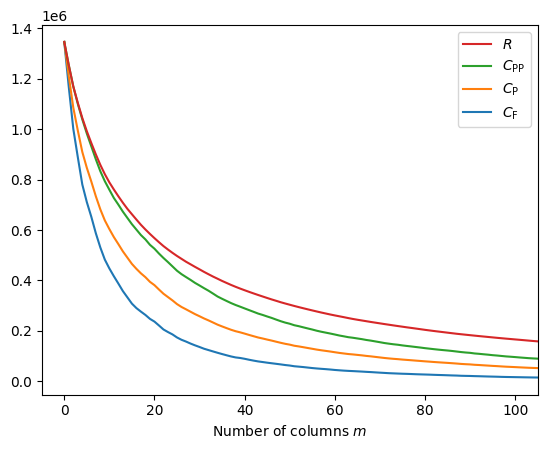

In [15]:
plt.plot(np.arange(Q+1), np.concatenate([[K_Frob_sq], 
                                         FW_errors_df["Frob_err_rec"].to_numpy()**2]))
plt.plot(np.arange(Q+1), np.concatenate([[K_Frob_sq], 
                                         FW_errors_df["P_err_rec"].to_numpy()**2]))
plt.plot(np.arange(Q+1), np.concatenate([[K_Frob_sq], 
                                         FW_errors_df["PP_err_rec"].to_numpy()**2]))
plt.plot(np.arange(Q+1), np.concatenate([[K_Frob_sq], 
                                         FW_errors_df["R_rec"].to_numpy()]))
plt.xlim(-5, 105)
plt.legend(labels=["$C_{\mathrm{F}}$", "$C_{\mathrm{P}}$", "$C_{\mathrm{PP}}$", "$R$"], reverse=True)
plt.xlabel("Number of columns $m$")
plt.show()

### 4.2. S-MFW variant of Algorithm 1

The cell below computes the first $110$ iterations of the stochastic modified FW (S-MFW) variant of Algorithm 1 
(with $\mathbf{f}=\mathrm{diag}(\mathbf{K})$, $\varkappa=1$ and $\ell = 100$). 

In [16]:
n_iter = 110 ## number of iterations
f_vec = np.diag(K_mat).real ## restriction vector f
ell = 200 ## number of samples for the stochastic approximation of g
random_seed = 321   ## set a seed for reproducibility

In [17]:
rng = np.random.default_rng(random_seed)
S_MFW_data = seq_samp_S_MFW_iterate(n_iter, f_vec, ell, K_mat, S_mat, N, K_Frob_sq,
                                    with_errors=False, rng=rng) ## without computing norm errors

100%|██████████| 109/109 [00:00<00:00, 3405.18it/s]


Same thing, but with the computation of the evolution of the considered error maps ($C_{\mathrm{tr}}$, $C_{\mathrm{F}}$, $C_{\mathrm{P}}$ and $C_{\mathrm{PP}}$).

In [18]:
rng = np.random.default_rng(random_seed)
S_MFW_data_with_errors = seq_samp_S_MFW_iterate(n_iter, f_vec, ell, K_mat, S_mat, N, K_Frob_sq,
                                                with_errors=True, rng=rng) ## with computing norm errors
S_MFW_errors_df = pd.DataFrame(S_MFW_data_with_errors)

100%|██████████| 109/109 [00:16<00:00,  6.78it/s]


### 4.3. Comparison with squared-diagonal-random sampling

Below, columns are sampled at random (sequentially, without replacement) according to weights proportional to the square of the entries of $\text{diag}(\mathbf{K})$. 

In [19]:
random_seed = 5
rng = np.random.default_rng(random_seed)

K_sq_diag_vec = np.diag(K_mat).real**2
sq_diag_prob_vec = K_sq_diag_vec / sum(K_sq_diag_vec)
sq_diag_errors_dict = []

T = FW_errors_df["m_q"][Q-1]

sq_diag_rand_samp = rng.choice(N, size=T, replace=False, p=sq_diag_prob_vec)
sq_diag_trace_err_rec = np.zeros(T, dtype=float)
sq_diag_Frob_err_rec = np.zeros(T, dtype=float)
sq_diag_P_err_rec = np.zeros(T, dtype=float)
sq_diag_PP_err_rec = np.zeros(T, dtype=float)

for m in tqdm(range(T)):        
    err_dict = comp_Nystrom_errors(sq_diag_rand_samp[:(m+1)], K_mat)
    sq_diag_trace_err_rec[m] = err_dict["trace_err"]
    sq_diag_Frob_err_rec[m] = err_dict["Frob_err"]
    sq_diag_P_err_rec[m] = err_dict["P_err"]
    sq_diag_PP_err_rec[m] = err_dict["PP_err"]

100%|██████████| 110/110 [00:16<00:00,  6.69it/s]


Computation of the rank-optimal approximation errors (for approximation factors).  

In [20]:
trace_K = sum(K_eigval_vec)
opt_trace_errs = trace_K - np.cumsum(K_eigval_vec)
opt_Frob_errs = np.sqrt(np.abs(K_Frob_sq - np.cumsum(K_eigval_vec**2)))

Plot of the approximation factors $\mathscr{E}_{\mathrm{X}}$, $\mathrm{X} \in \{\mathrm{tr}, \mathrm{F}, \mathrm{P}, \mathrm{PP}\}$, against the number of columns $m$ for squared-diagonal-random sampling, Algorithm 1 (FW) and Algorithm 1 (S-MFW). 

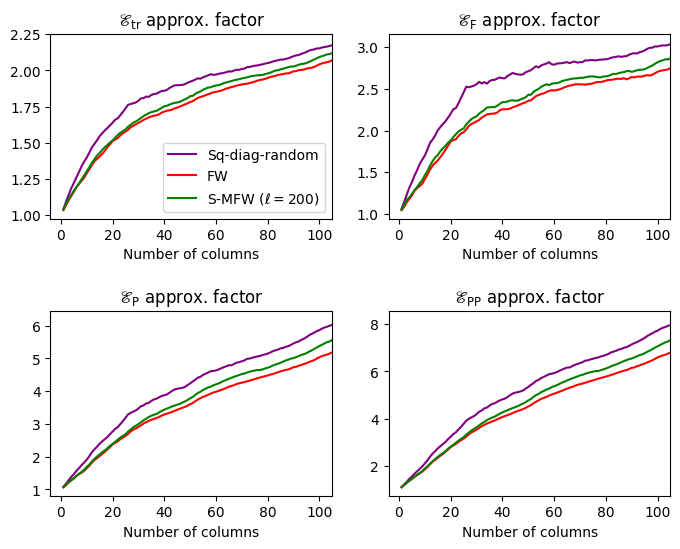

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
plt.subplots_adjust(hspace=0.5)
                    
ax[0, 0].plot(np.arange(1, T+1), 
              sq_diag_trace_err_rec / opt_trace_errs[:T], color="purple")
ax[0, 0].plot(np.arange(1, T+1), 
              FW_data_with_errors["trace_err_rec"] / opt_trace_errs[:T], color="red")
ax[0, 0].plot(np.arange(1, T+1), 
              S_MFW_data_with_errors["trace_err_rec"] / opt_trace_errs[:T], color="green")
ax[0, 0].set_xlim(-4, 105)
ax[0, 0].set_title("$\mathscr{E}_{\mathrm{tr}}$ approx. factor")
ax[0, 0].set(xlabel="Number of columns")
ax[0, 0].legend(labels=["Sq-diag-random", "FW", "S-MFW ($\ell = 200$)"])

ax[0, 1].plot(np.arange(1, T+1), 
              sq_diag_Frob_err_rec / opt_Frob_errs[:T], color="purple")
ax[0, 1].plot(np.arange(1, T+1), 
              FW_data_with_errors["Frob_err_rec"] / opt_Frob_errs[:T], color="red")
ax[0, 1].plot(np.arange(1, T+1),
              S_MFW_data_with_errors["Frob_err_rec"] / opt_Frob_errs[:T], color="green")
ax[0, 1].set_xlim(-4, 105)
ax[0, 1].set_title("$\mathscr{E}_{\mathrm{F}}$ approx. factor")
ax[0, 1].set(xlabel="Number of columns")

ax[1, 0].plot(np.arange(1, T+1), 
              sq_diag_P_err_rec / opt_Frob_errs[:T], color="purple")
ax[1, 0].plot(np.arange(1, T+1), 
              FW_data_with_errors["P_err_rec"] / opt_Frob_errs[:T], color="red")
ax[1, 0].plot(np.arange(1, T+1),
              S_MFW_data_with_errors["P_err_rec"] / opt_Frob_errs[:T], color="green")
ax[1, 0].set_xlim(-4, 105)
ax[1, 0].set_title("$\mathscr{E}_{\mathrm{P}}$ approx. factor")
ax[1, 0].set(xlabel="Number of columns")

ax[1, 1].plot(np.arange(1, T+1), 
              sq_diag_PP_err_rec / opt_Frob_errs[:T], color="purple")
ax[1, 1].plot(np.arange(1, T+1), 
              FW_data_with_errors["PP_err_rec"] / opt_Frob_errs[:T], color="red")
ax[1, 1].plot(np.arange(1, T+1),
              S_MFW_data_with_errors["PP_err_rec"] / opt_Frob_errs[:T], color="green")
ax[1, 1].set_xlim(-4, 105)
ax[1, 1].set_title("$\mathscr{E}_{\mathrm{PP}}$ approx. factor")
ax[1, 1].set(xlabel="Number of columns")

plt.show()